<a href="https://colab.research.google.com/github/Edward-TL/amazon_scraper/blob/master/Amazon_Mx_Music_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wG-L5xdLmhjz0jebwtAbPQuIpjVRJsZ9U3IgNACeD35KDuVlRB9h20
Mounted at /content/drive


# Import

In [ ]:
#For the system
import os

#Manage of time
from datetime import datetime, timedelta
from pytz import timezone
import time
import re

#Manage of files
import pandas as pd
import csv

#Graph tools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patches as mpatches

#interactive visualization

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

plt.show = plt.gcf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%cd 'drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet'
!ls

/content/drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet
mx-master_db_amazon-devices.parquet  mx-master_db_kitchen.parquet
mx-master_db_automotive.parquet      mx-master_db_musical-instruments.parquet
mx-master_db_baby.parquet	     mx-master_db_music.parquet
mx-master_db_books.parquet	     mx-master_db_officeproduct.parquet
mx-master_db_digital-text.parquet    mx-master_db_pet-supplies.parquet
mx-master_db_dvd.parquet	     mx-master_db_shoes.parquet
mx-master_db_electronics.parquet     mx-master_db_software.parquet
mx-master_db_grocery.parquet	     mx-master_db_sports.parquet
mx-master_db_handmade.parquet	     mx-master_db_tools.parquet
mx-master_db_hpc.parquet	     mx-master_db_toys.parquet
mx-master_db_industrial.parquet      mx-master_db_videogames.parquet


In [ ]:
df = pd.read_parquet('mx-master_db_music.parquet')

# Tools

## Count if

In [ ]:
def count_if(array, value):
    count = 0
    for element in array:
        if element == value:
            count += 1
    return count

## array count

In [ ]:
def array_count(elements_to_count, original_array):
    count_array = [None] * len(elements_to_count)
    c = 0

    for value in range(len(elements_to_count)):
        count_array[c] = original_array.count(elements_to_count[value])
        c += 1
        
    return count_array

## rank set list

In [ ]:
def rank_set_list(df, rank, info, set_list=True, array=True):
    ranking = df[df['Rank'] == rank]
    raw_info_in_rank = ranking[info].to_list()

    if set_list == True:
        set_info = list(set(raw_info_in_rank))
        none_cases = count_if(set_info, None)
        if none_cases > 0:
            set_info.remove(None)

        if array == True:
            return set_info, raw_info_in_rank

        else: return set_info
    
    else: return raw_info_in_rank

    

In [ ]:
def rank_info(df, rank, column_info, info_name='Albums'):
    set_info, raw_info_in_rank = rank_set_list(df, rank, column_info)
    info_count = array_count(elements_to_count=set_info, original_array=raw_info_in_rank)
    info = {info_name: set_info,
            'Counts' : info_count}
    df_info = pd.DataFrame(info)
    df_info = df_info.sort_values(by=['Counts'])

    return df_info

In [ ]:
def plot_rank_barh(x, y, rank):
    plt.figure(figsize=(8,8))
    plt.barh(y=y, width=x)

    for i, v in enumerate(x):
        plt.text(v+1, i, str(v), fontweight='bold')

    xlabel = f'Times shown at #{rank} position' 
    plt.xlabel(xlabel)

    header = f'Times an album hit the #{rank} position' 
    plt.title(label=header)

    plt.show()

In [ ]:
def barh_and_scatters(pivot_column, df_info=df, top_rank=5, extracted_info_name='Albums', n_plots=1):

    top = top_rank + 1 
    info = pivot_column
    df = df_info

    for rank in range(1, top):
        
        #Extract Info
        
        extracted_df = rank_info(df, rank, info, extracted_info_name)
        albums = extracted_df[extracted_info_name].to_list()
        info_count = extracted_df['Counts'].to_list()

        #Plot
        plot_rank_barh(info_count, albums, rank)

        # scatter
        rank_df = df[df['Rank'] == rank]
        x = rank_df['Stars']
        y = rank_df['Reviews']
        
        groups = rank_df.groupby(info)        
        markers = ['o', 'x', 'v', 'p']
        fig, ax = plt.subplots()
        m = 0
        p = 0
        

        for name, group in groups:
            if (m % 10 == 0) and (m > 0):
                p += 1

            ax.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
            m += 1

        plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)

In [ ]:
def barh_plus_scatter(pivot_column, df_info=df, top_rank=5, extracted_info_name='Albums', n_plots=1, w_fig=8, h_fig=8):
    top = top_rank + 1 
    info = pivot_column
    df = df_info

    for rank in range(1, top):
        
        #Extract Info
        
        extracted_df = rank_info(df, rank, info, extracted_info_name)
        albums = extracted_df[extracted_info_name].to_list()
        info_count = extracted_df['Counts'].to_list()

        #Plot
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(w_fig, h_fig))
        title = f' Top #{rank} Info' 
        fig.suptitle(title)
        # plt.figure(figsize=(w_fig,h_fig))

        ax1.barh(y=albums, width=info_count)

        for i, v in enumerate(info_count):
            ax1.text(v+1, i, str(v))

        xlabel = f'Times shown at #{rank} position' 
        ax1.set_xlabel(xlabel)

        bar_header = f'Times an {extracted_info_name} hit the #{rank} position' 
        ax1.set_title(label=bar_header)

        # scatter
        rank_df = df[df['Rank'] == rank]
        x = rank_df['Stars']
        y = rank_df['Reviews']
        
        ax2.set_xlabel('Stars')
        ax2.set_title(f'Reviews vs Stars per {extracted_info_name} at the #{rank} position')
        ax2.set_ylabel('Reviews')
        groups = rank_df.groupby(info)        
        markers = ['o', 'x', 'v', 'p']
        
        m = 0
        p = 0
        for name, group in groups:
            if (m % 10 == 0) and (m > 0):
                p += 1
            ax2.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
            
            m += 1

        ax2.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)
        plt.show()
        

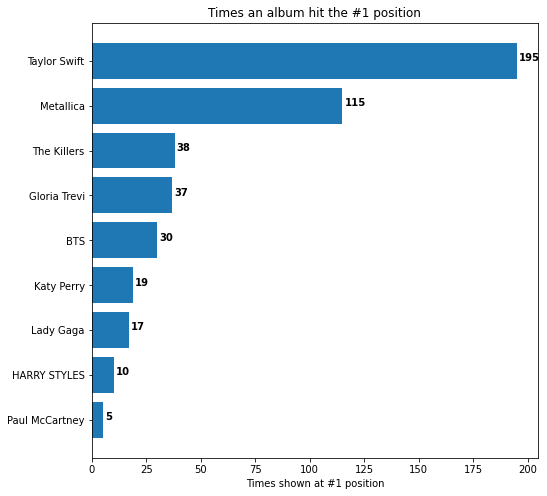

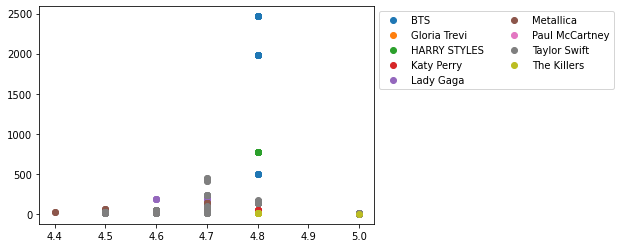

In [ ]:
artist = 'Authors/Company'
barh_and_scatters(artist, top_rank=1)


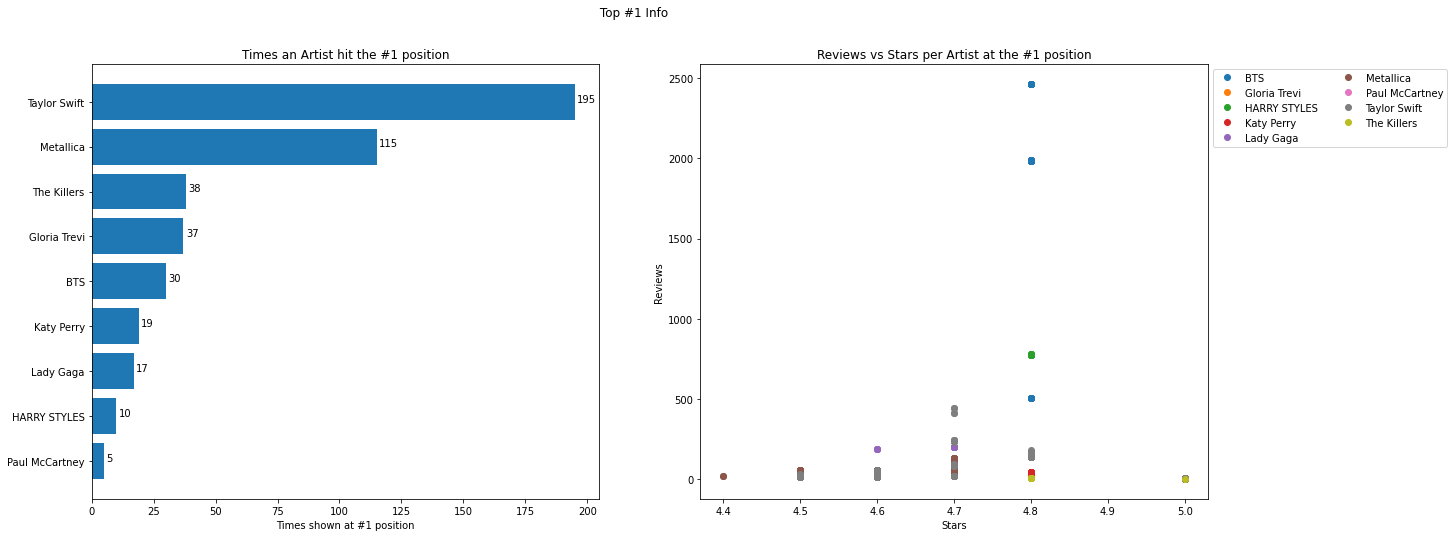

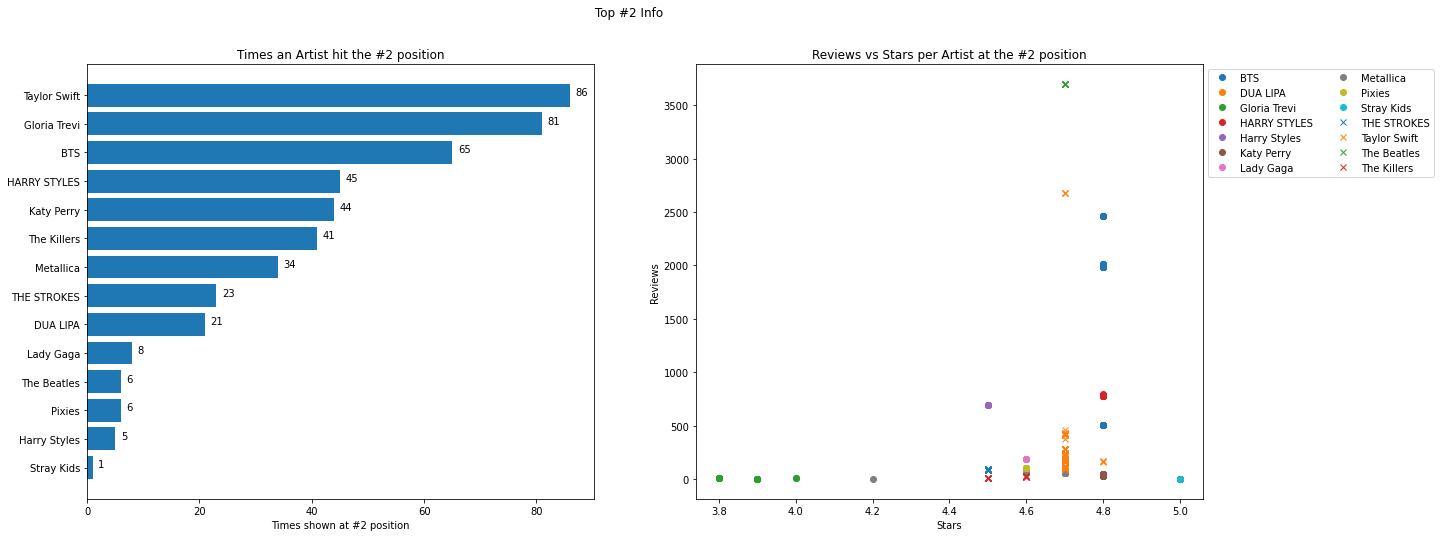

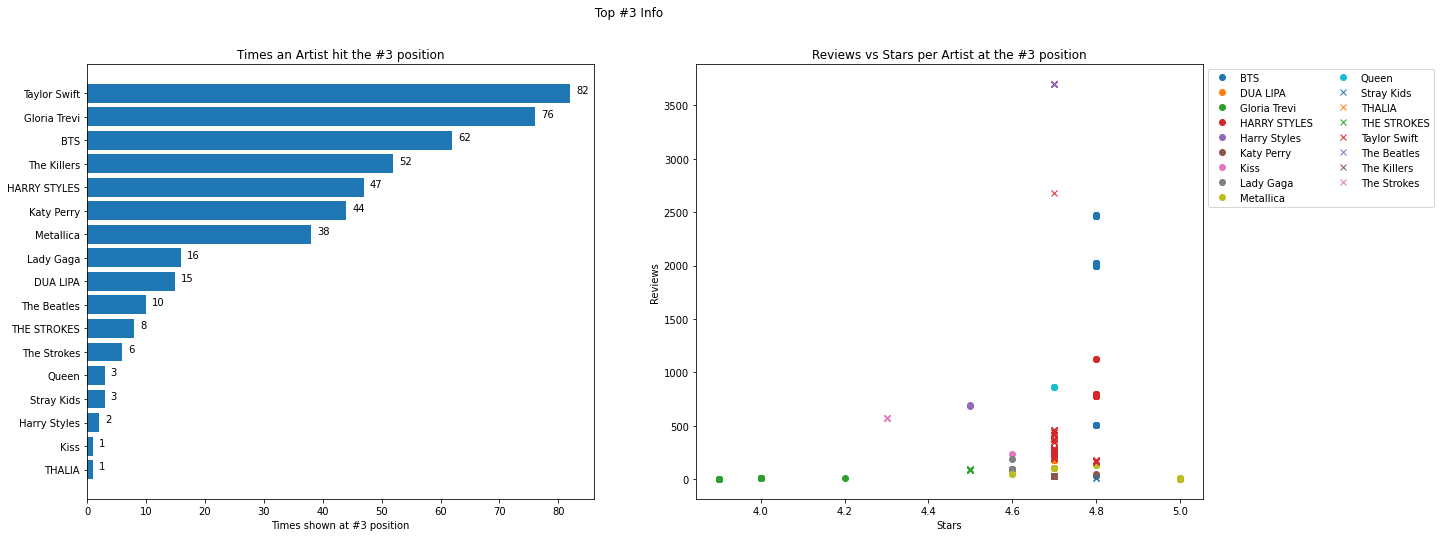

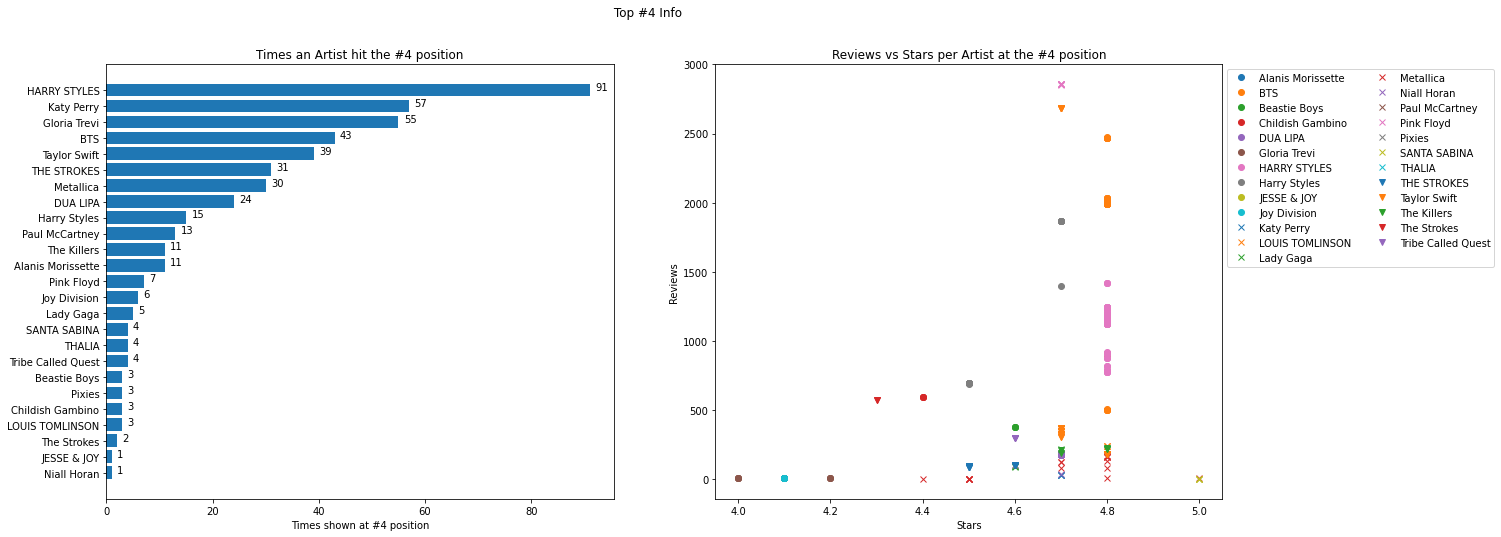

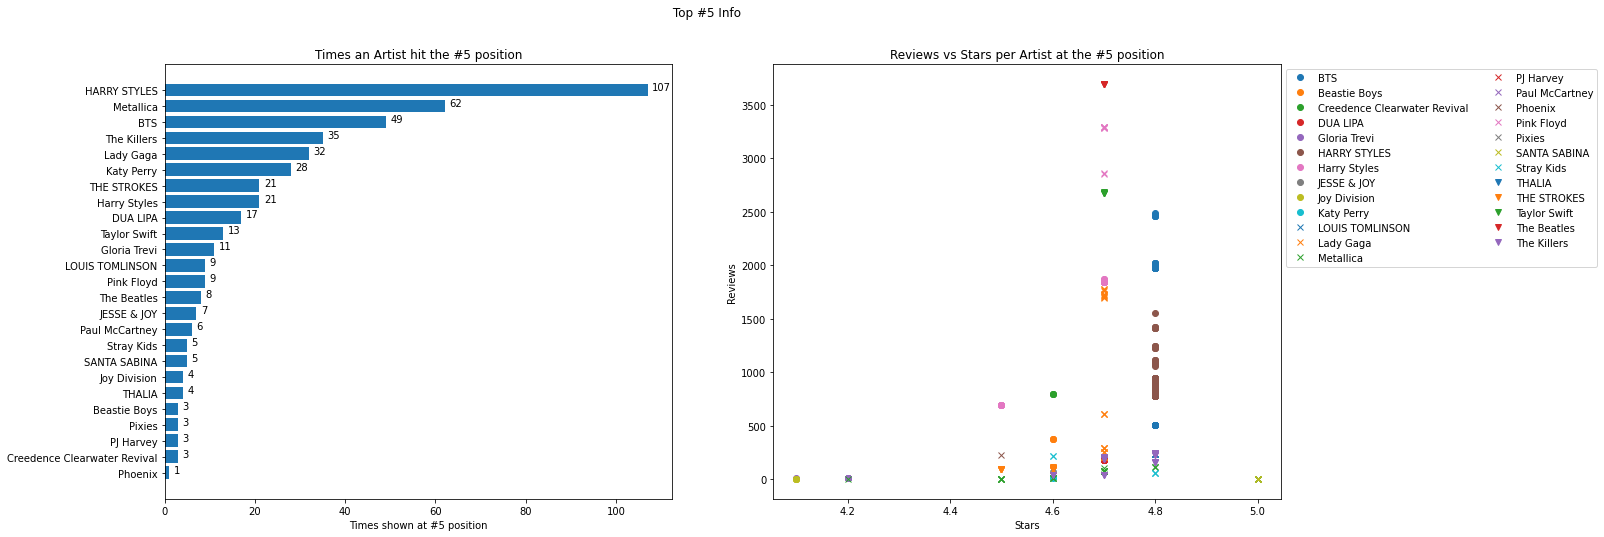

In [ ]:
barh_plus_scatter(artist, extracted_info_name='Artist' , top_rank=5, w_fig=20, h_fig=8)

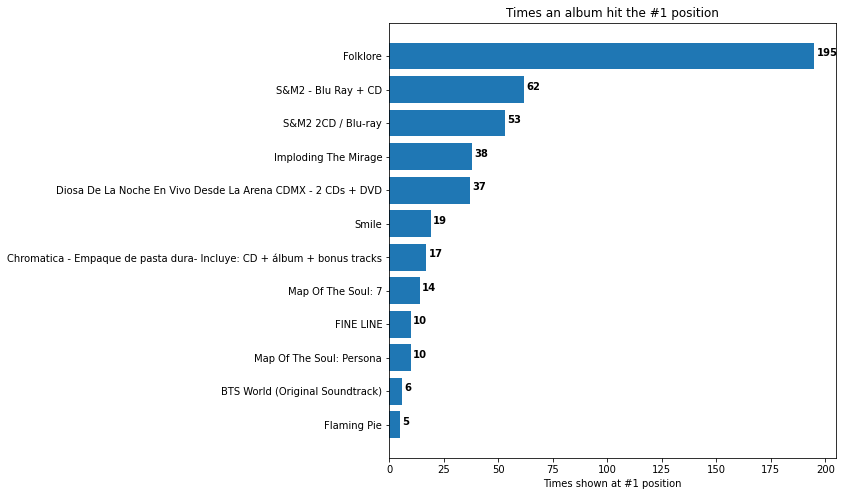

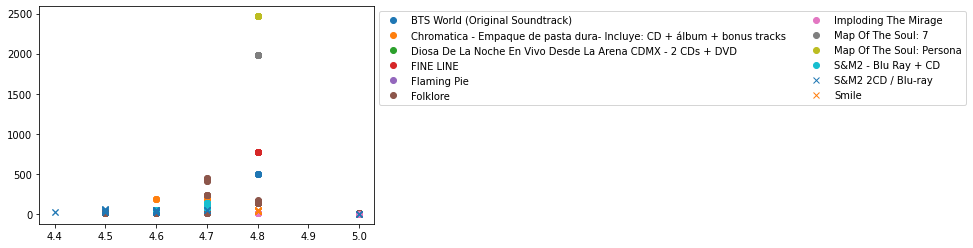

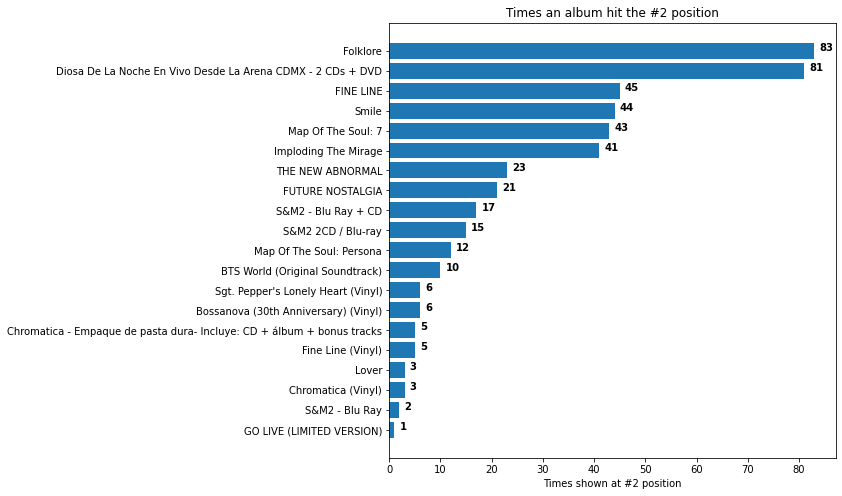

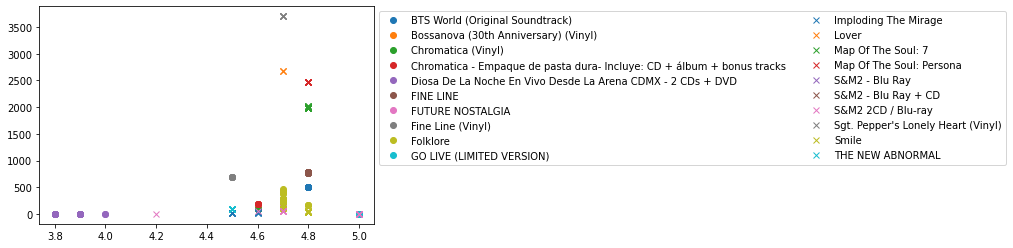

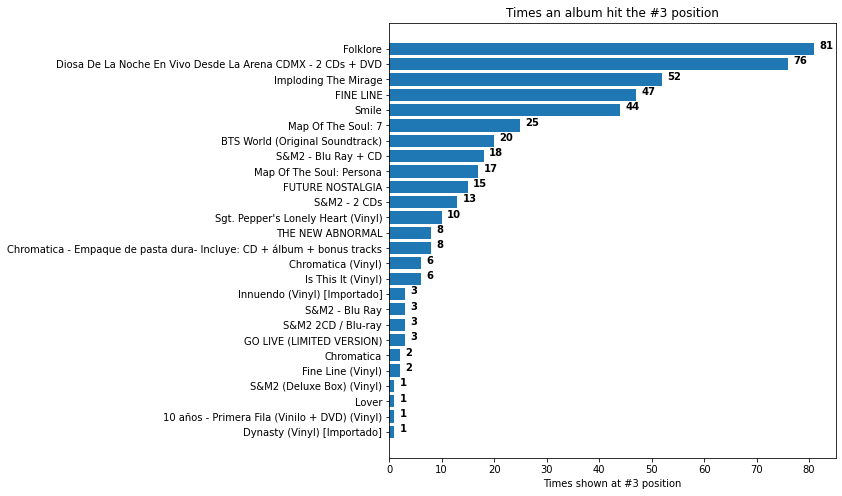

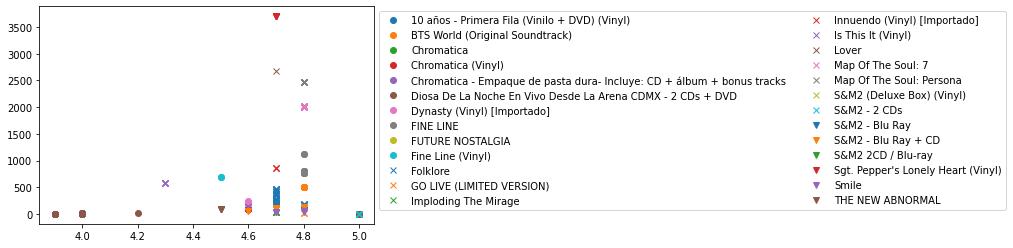

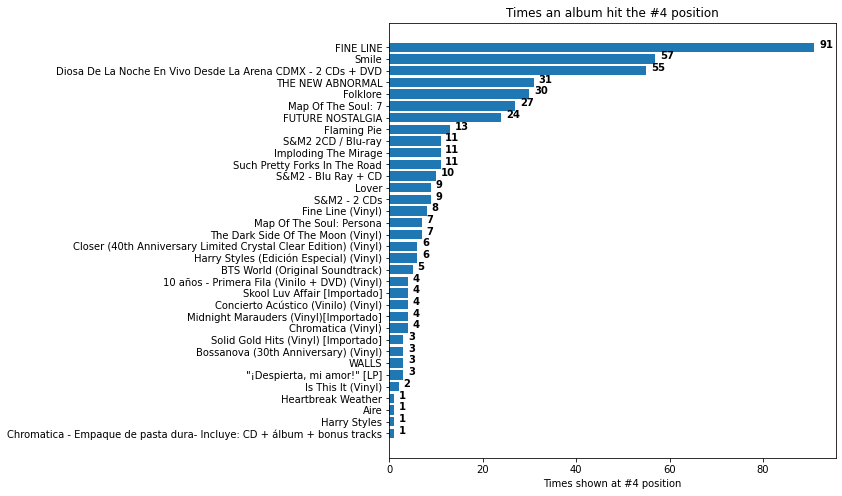

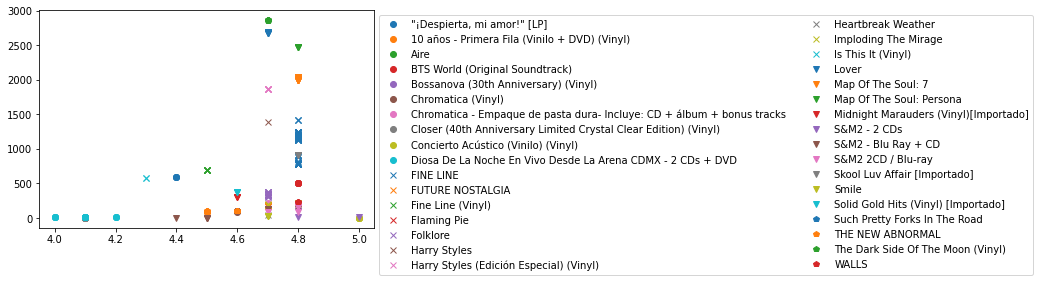

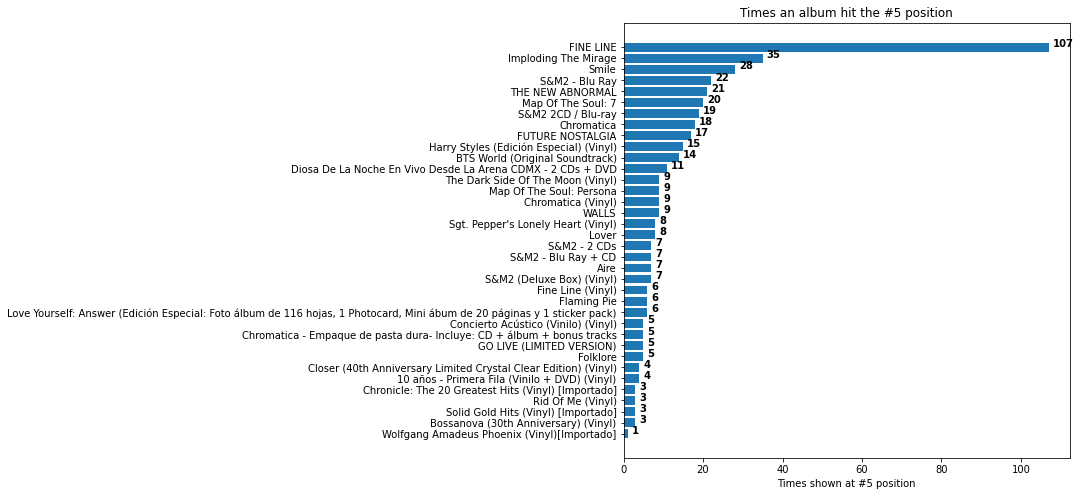

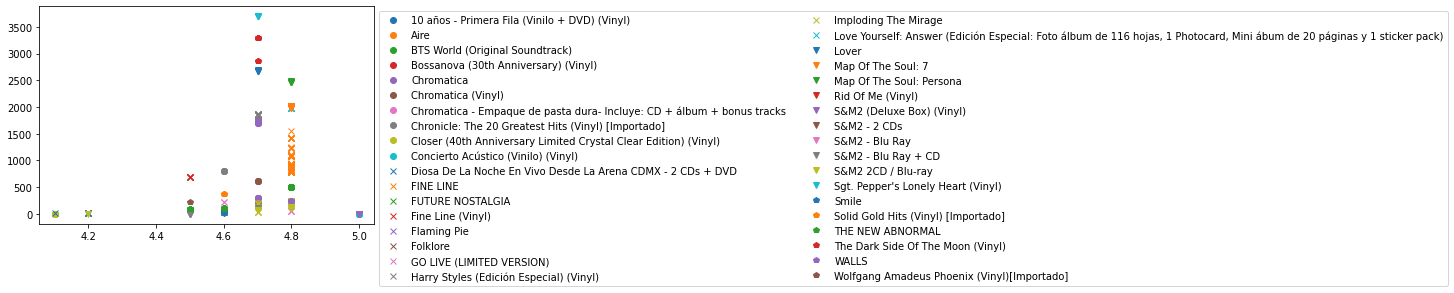

In [ ]:
album = 'Product Names'
barh_and_scatters(album)

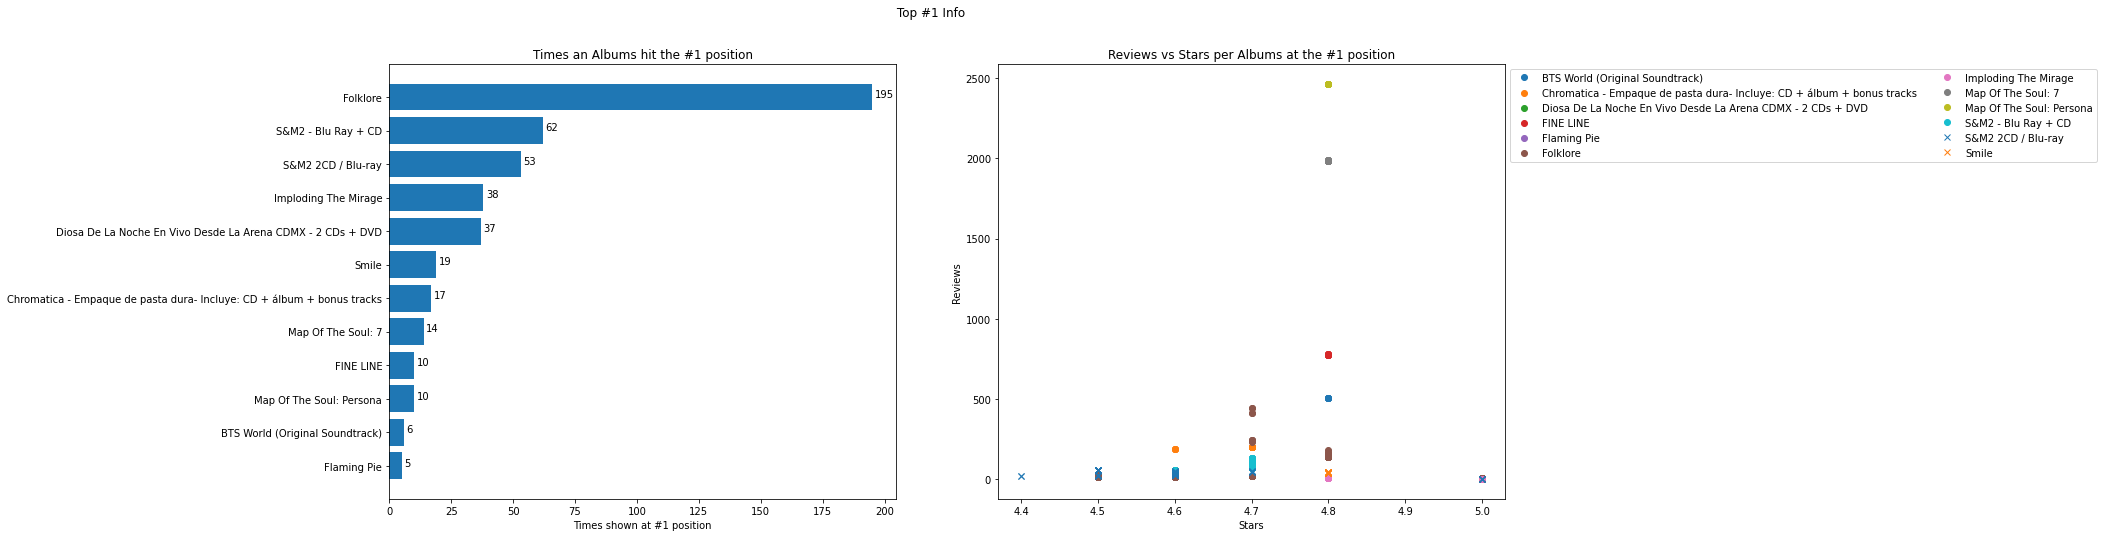

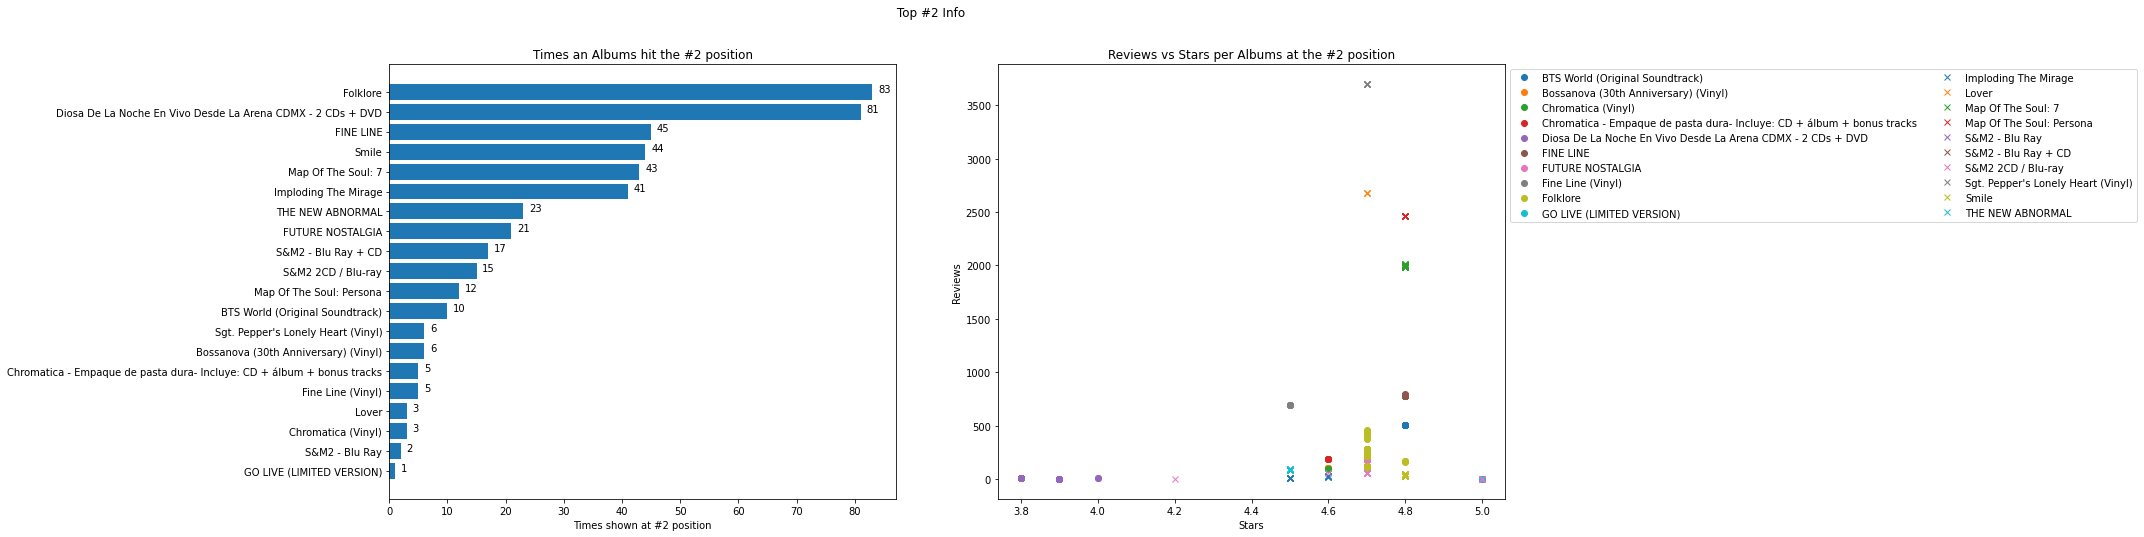

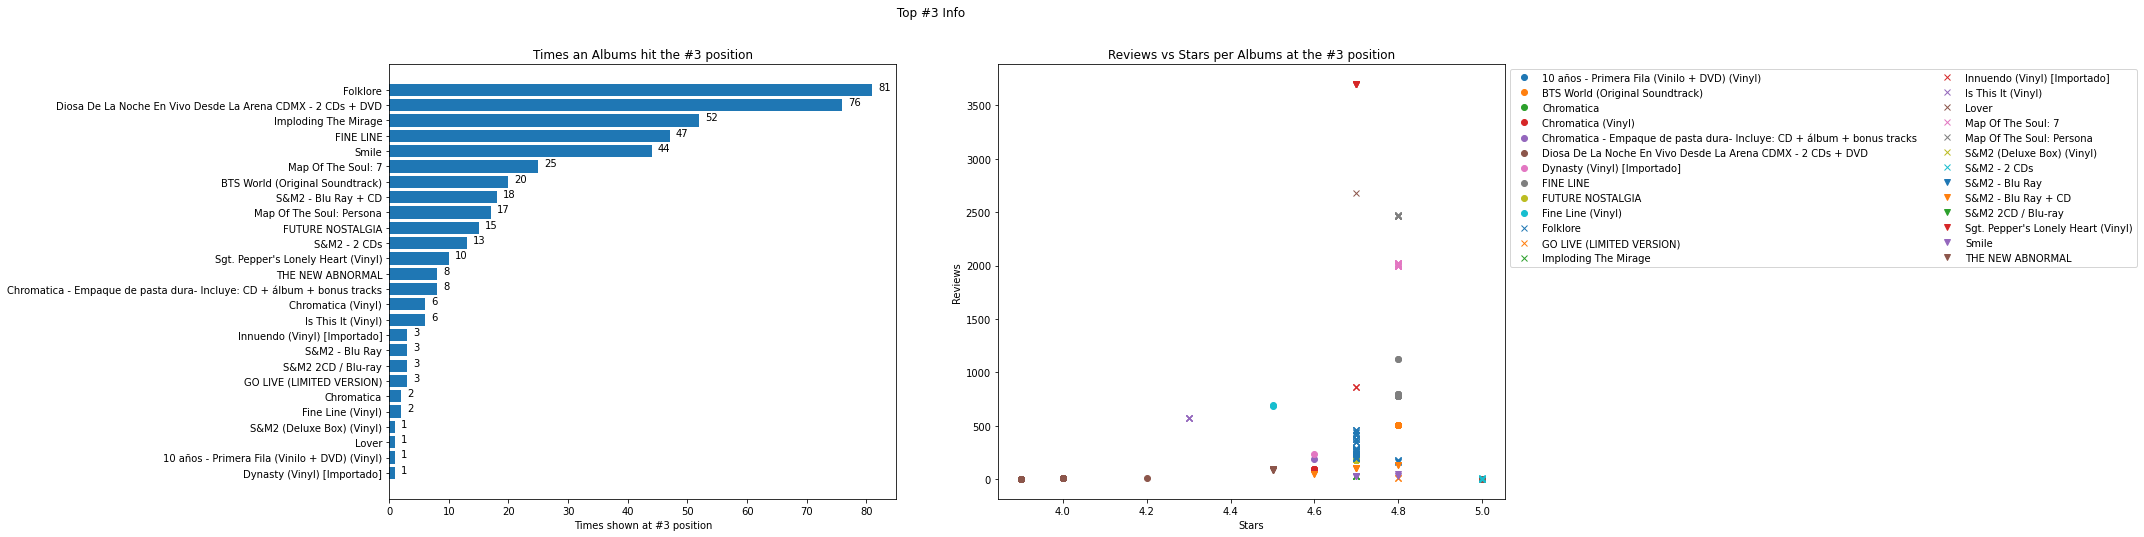

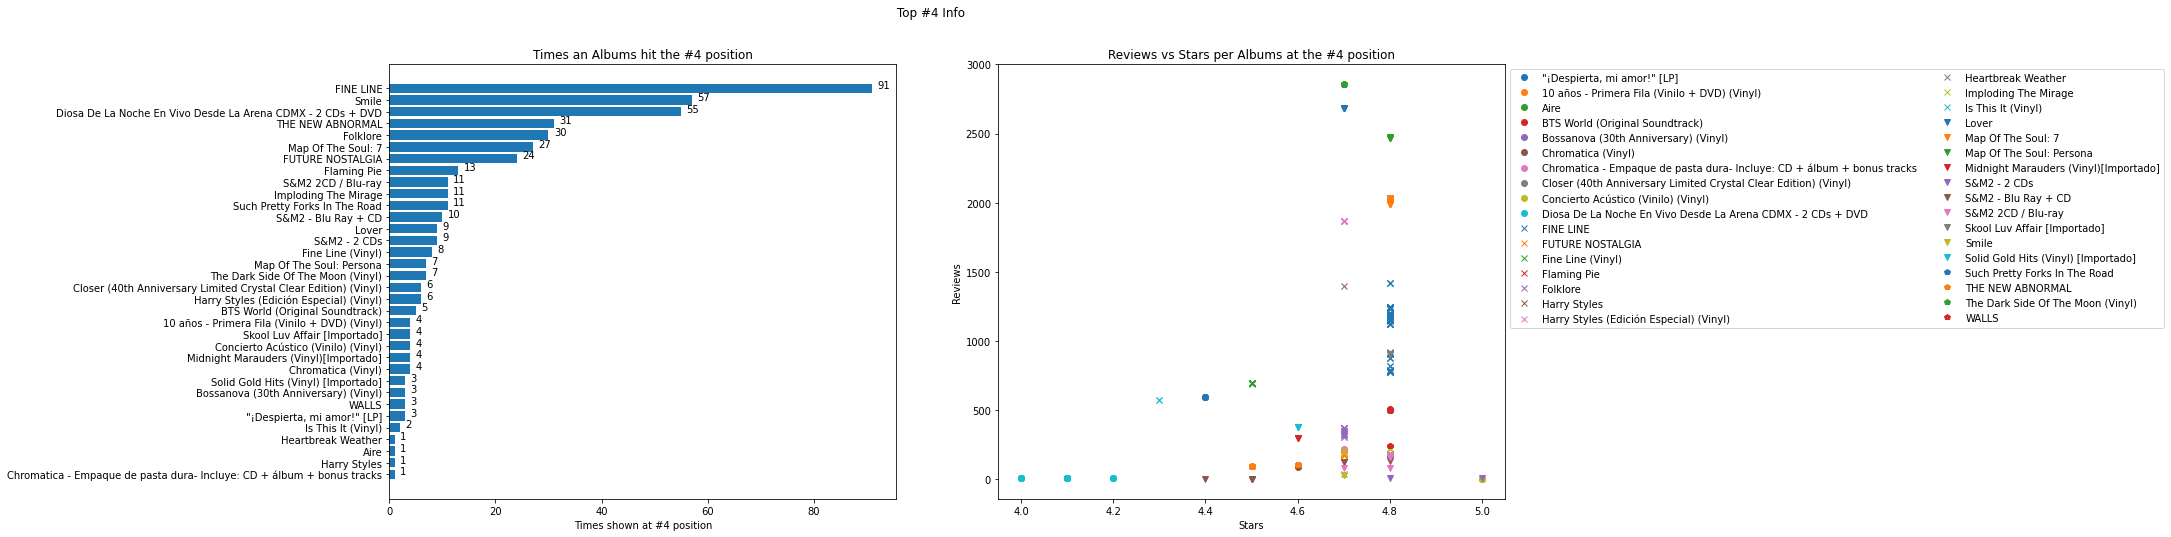

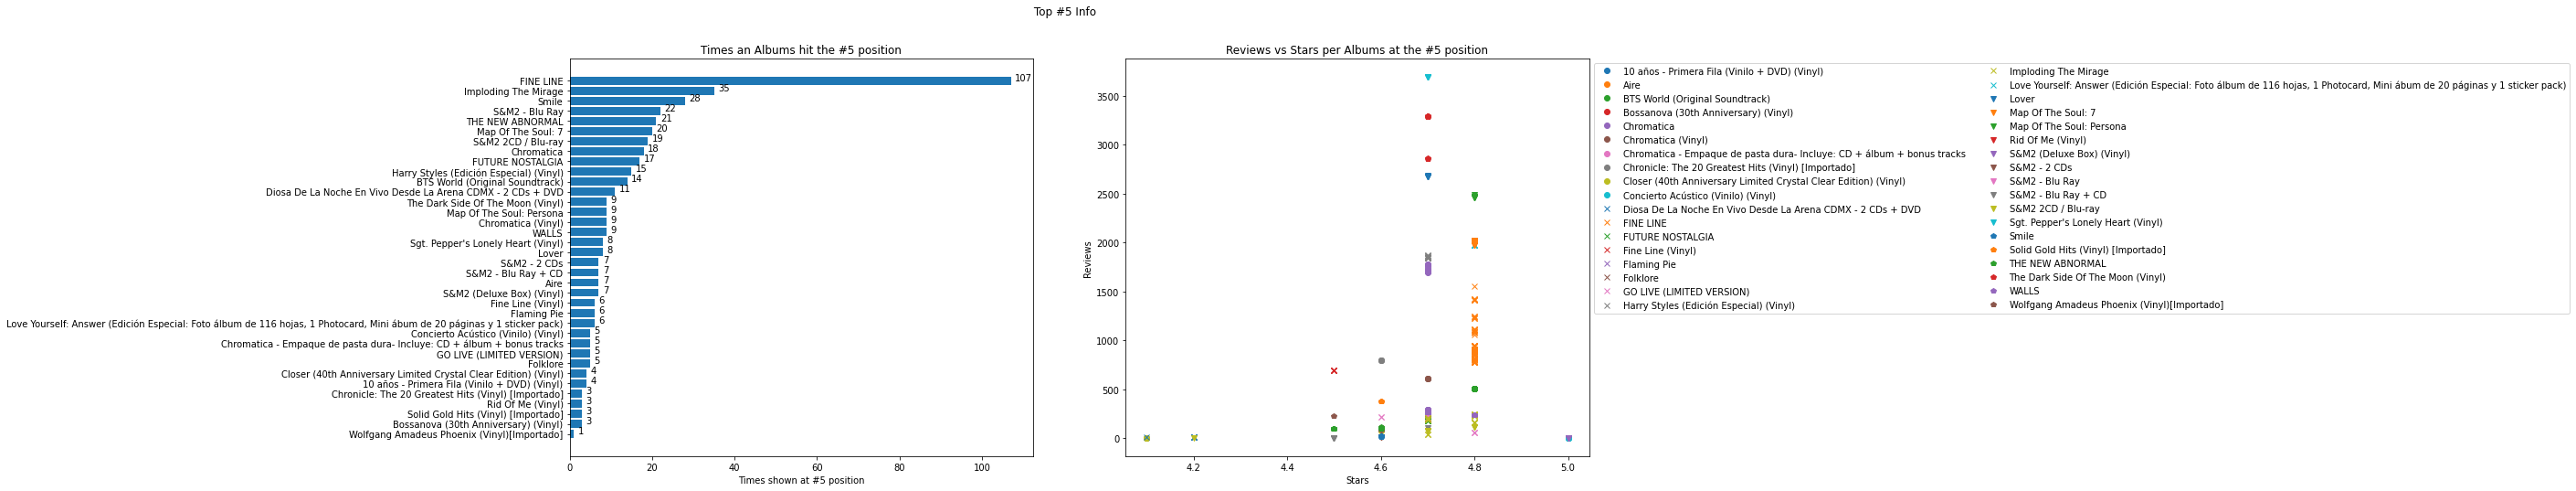

In [ ]:
barh_plus_scatter(album, top_rank=5, w_fig=20, h_fig=8)

# Plots

In [ ]:
def reverse(array):
    reversed_array = [None]*len(array)
    n = 0
    for data in reversed(array):
        reversed_array[n] = data
        n += 1

    return reversed_array

In [ ]:
extracted_df = rank_info(df, 1, artist, 'Artist/Band')
labels = extracted_df['Artist/Band'].to_list()
labels_count = extracted_df['Counts'].to_list()
print(labels)
labels = reverse(labels)
print(labels)

['Paul McCartney', 'HARRY STYLES', 'Lady Gaga', 'Katy Perry', 'BTS', 'Gloria Trevi', 'The Killers', 'Metallica', 'Taylor Swift']
['Taylor Swift', 'Metallica', 'The Killers', 'Gloria Trevi', 'BTS', 'Katy Perry', 'Lady Gaga', 'HARRY STYLES', 'Paul McCartney']


In [ ]:
def row_1_barh_and_lines(rank, extracted_df, info, extracted_info_name, labels, labels_count, original_df=df, line_colors=main_colors):
    df = original_df
    bar_header = f'Times an album hit the top #{rank}'
    line_header = f'{extracted_info_name} Rank History'
    
    
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'bar'}, {'type': 'scatter'}]],
        subplot_titles=(bar_header, line_header)
        )

    #Horizontal Bars
    fig.add_trace(
        go.Bar(
            x = labels_count, y = labels, orientation = 'h',
            showlegend = False,
            text = labels,
                hovertemplate=
                "<b>%{text}</b><br><br>" +
                "Times: %{x}<br>" 
            ), row = 1, col = 1)
    fig.update_traces(marker_color='#F58518')
    fig.update_yaxes(title_text=extracted_info_name, row=1, col=1)
    # fig.update_xaxes(title_text=f'Times hited the top#{rank}', row=1, col=1)
    

    #lines
    labels = reverse(labels)
    color = 0
    for label in labels:
        best_seller = df[df[info] == label]
        fig.add_trace(
            go.Scatter(
                x = best_seller.time, y = best_seller.Rank, mode = 'lines', name = label, line=dict(color = line_colors[color]),
                text = best_seller[info],
                hovertemplate=
                "<b>%{text}</b><br><br>" +
                "Time: %{x}<br>" +
                "Rank Position: #%{y:,0f}<br>"
                ), row=1, col=2)
        if color < (len(line_colors)-1):
            color += 1
        else:
            color = 0
    # fig.update_layout(yaxis=dict(autorange = "reversed"), row=1, col=2)
    fig.update_yaxes(title_text='Rank Position', range=[1,50], row=1, col=2, autorange="reversed")
    fig.update_xaxes(title_text='Date' , row=1, col=2)


    fig.update_layout(
        title = {
            'text' : f"Amazon Music's sells at web page. Top #{rank} Info",
            'x' : 0.5,
            'xanchor' : 'center',
            'yanchor' : 'top',
            'y' : 0.9
        },
        title_font_size = 30,
        margin = dict(r=10, t=100, b=0, l=10),
        height = 400,
    )
    
    fig.show()

In [ ]:
def row_2_rank_boxes(rank, info,  extracted_info_name, labels, original_df=df, box_colors=main_colors):
    df = original_df
    ranking_box_header = f'Ranking distribution of the {extracted_info_name} at Top #{rank}:'  

    fig2 = make_subplots(
        rows=1, cols=1,
        specs=[[{'type': 'Box'}]]
        )
    color = 0
    for label in labels:
        info_df = df[df[info] == label]
        fig2.add_trace(
                go.Box(
                    y = info_df.Rank, showlegend = False,
                    name = label,
                    marker_color = box_colors[color]
                ))
        if color < (len(box_colors)-1):
            color += 1
        else:
            color = 0

    fig2.update_layout(
        margin=dict(r=10, t=40, b=50, l=10),
        height=300,
        title_text = ranking_box_header
    )
    fig2.update_yaxes(title_text='Rank Position', range=[1,50], autorange="reversed", row=1, col=1)
    fig2.show()

In [ ]:
def row_3_boxes_and_scatter(rank, df, info, labels, scatter_colors=main_colors):
    box_header = f'Stats of of the #{rank} position'
    scatter_header = f'Reviews vs Stars of the #{rank} position'

    fig3 = make_subplots(
        rows=1, cols=5,
        column_widths=[0.19, 0.19, 0.19, 0.005, 0.425],
        specs=[[{'type': 'box'}, {'type': 'box'}, {'type': 'box'}, None, {'type': 'scatter'}]],
        subplot_titles=(None, box_header, None, scatter_header, None)
    )
    
    #BOXES INFO
    top_5 = df[(df['Rank'] >= 1) & (df['Rank']<=5)]
    rank_df = df[df['Rank'] == rank]
    box_info = ['Stars', 'Reviews', 'Price_std_or_min']
    colors = ['#FECB52', 'gold', 'crimson', 'red','green','lightseagreen']

    #Box
    b = 1
    c = 0
    for i in box_info:
        fig3.add_trace(
            go.Box(
                y = top_5[i], showlegend = False,
                name = f'Tops 1-5',
                marker_color = colors[c],
            ), row = 1, col = b)
        
        c += 1

        fig3.add_trace(
            go.Box(
                y = rank_df[i], showlegend = False,
                name = f'Top {rank}',
                marker_color = colors[c],
            ),
            row = 1, col = b)
        if i == 'Price_std_or_min':
            i = 'Price'
        fig3.update_xaxes(title_text=i, row=1, col=b)
        b += 1
        c += 1 

    #Scatter
    groups = rank_df.groupby(info)
    color = 0 
    for label in labels:
        best_seller = df[df[info] == label]
        fig3.add_trace(
            go.Scatter(
                x = best_seller.Stars, y = best_seller.Reviews, mode = 'markers', name = label, marker=dict(color = scatter_colors[color]),
                text = best_seller[artist],
                hovertemplate=
                "<b>%{text}</b><br><br>" +
                "Stars: %{x}<br>" +
                "Reviews: %{y:,0f}<br>"
                ), row = 1, col = 5)
        if color < (len(scatter_colors)-1):
            color += 1
        else:
            color = 0

    fig3.update_yaxes(title_text="Reviews", row=1, col=5)
    fig3.update_xaxes(title_text="Stars", row=1, col=5)
    fig3.update_layout(
        margin=dict(r=10, t=40, b=50, l=10),
        height=300,
    )

    fig3.show()

In [ ]:
main_colors = px.colors.qualitative.Bold
print(main_colors)

['rgb(127, 60, 141)', 'rgb(17, 165, 121)', 'rgb(57, 105, 172)', 'rgb(242, 183, 1)', 'rgb(231, 63, 116)', 'rgb(128, 186, 90)', 'rgb(230, 131, 16)', 'rgb(0, 134, 149)', 'rgb(207, 28, 144)', 'rgb(249, 123, 114)', 'rgb(165, 170, 153)']


In [115]:
def plotly_figures(info, df, main_colors, rank, extracted_info_name):
    extracted_df = rank_info(df, rank, info, extracted_info_name)
    labels = extracted_df[extracted_info_name].to_list()
    labels_count = extracted_df['Counts'].to_list()
    row_1_barh_and_lines(rank, extracted_df, info, extracted_info_name, labels, labels_count, df, line_colors=main_colors)

    #FIGURE 2
    labels = reverse(labels)
    row_2_rank_boxes(rank, info, extracted_info_name, labels, df, box_colors=main_colors)

    #FIGURE 3
    #Labels are reversed in order to match with the other graphs
    row_3_boxes_and_scatter(rank, df, info, labels, scatter_colors=main_colors)

In [116]:
def dashboard(pivot_column, rank=1, df_info=df, top_rank=None, extracted_info_name='Albums'):    
    info = pivot_column
    df = df_info
    main_colors = px.colors.qualitative.Bold
    
    if top_rank:
        top = top_rank + 1 
        for rank in range(rank, top):
            plotly_figures(info, df, main_colors, rank, extracted_info_name)
    
    else:
        plotly_figures(info, df, main_colors, rank, extracted_info_name)


In [120]:
dashboard(artist, rank=1, extracted_info_name="Artist/Band")

In [ ]:
rank = 1
#Rank Lines

extracted_df = rank_info(df, rank, artist, 'Artist')
labels = extracted_df['Artist'].to_list()
labels_count = extracted_df['Counts'].to_list()

fig = go.Figure()

for label in labels:
    best_seller = df[df[artist] == label]
    fig.add_trace(
        go.Scatter(
            x = best_seller.time, y = best_seller.Rank, mode = 'lines', name = label,
            text = best_seller[artist],
            hovertemplate=
            "<b>%{text}</b><br><br>" +
            "Time: %{x}<br>" +
            "Rank Position: #%{y:,0f}<br>"
            ))
    fig.update_layout(yaxis=dict(autorange = "reversed"))
    fig.update_yaxes(range=[1,50])
# fig['layout']['yaxis']['autorange'] = "reversed"
fig.show()

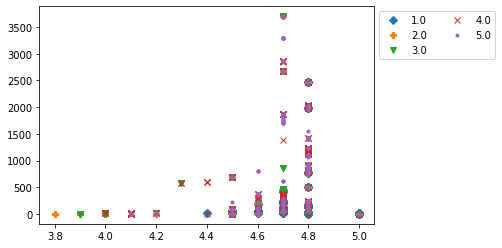

In [ ]:
top_5 = df[(df['Rank'] >= 1) & (df['Rank']<=5)]
groups = top_5.groupby('Rank')
# Plot
fig, ax = plt.subplots()

p = 0
markers = ['D', 'P', 'v', 'x', '.']

for name, group in groups:
    ax.plot(group.Stars , group.Reviews, marker=markers[p], linestyle='', label=name)
    p += 1

plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)